# Exp018: Instruction fine-tuning for constrained text generation
This experiment aims at instruction fine-tuning from existing skills in the dataset to train the model on single constraints.

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['CACHE_DIR'] = f"/scratch/tmp.{os.getenv('SLURM_JOB_ID')}.dglandorf" # speed up model loading
os.environ['WANDB_DIR'] = os.getenv('CACHE_DIR')

from tqdm.notebook import tqdm
from transformers import TrainingArguments
import datasets
datasets.disable_caching()

from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
import pickle
from torch.utils.data import RandomSampler
import numpy as np
import json
from peft import LoraConfig, PeftModel, get_peft_model
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
import sys
sys.path.append(f'../source')
import helpers
import models
import evaluation
import importlib
#importlib.reload(models)

2024-04-15 20:40:46.107372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to
[nltk_data]     /cluster/home/dglandorf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# params
input_file = '../data/corpus_classification_all.pkl'
preprossed_dataset_file = '../data/SFT_data.jsonl'
checkpoint_dir = '/cluster/scratch/dglandorf/models/'
nrs = list(evaluation.detector.classifiers.keys())


## Prepare dataset

In [25]:
if not os.path.exists(preprossed_dataset_file):
    with open(input_file, 'rb') as f:
        all_hit_indices = pickle.load(f)
        all_hit_sentences = pickle.load(f)
        extracts = pickle.load(f)
    
    data = [{"context": extracts[idx][0],
             "response": extracts[idx][1],
             "constraints": [nr],
             "source": extracts[idx][2],} for nr in nrs for idx in all_hit_indices[nr]]
    
    with open(preprossed_dataset_file, 'w') as f:
        for item in tqdm(data):
            f.write(json.dumps(item) + '\n')

  0%|          | 0/234775 [00:00<?, ?it/s]

### Load dataset

In [3]:
nrs_to_consider = [628]

dataset = datasets.load_dataset('json', data_files=preprossed_dataset_file, split='train')
dataset = dataset.filter(lambda item: any(item['constraints']==[nr] for nr in nrs_to_consider))
dataset = dataset.map(helpers.get_generation_prompt)
seen_texts = set()
def filter_duplicates(item):
    if item['text'] in seen_texts:
        return False
    else:
        seen_texts.add(item['text'])
        return True
dataset = dataset.filter(filter_duplicates)
train_test_split = dataset.train_test_split(test_size=100 if len(dataset)>500 else 0.2)
train_dataset, test_dataset = train_test_split['train'], train_test_split['test']

unconstrained = test_dataset.map(helpers.get_generation_prompt, fn_kwargs={"unconstrained": True})

Filter:   0%|          | 0/242518 [00:00<?, ? examples/s]

Map:   0%|          | 0/3687 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3687 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

## Load and prepare base model

In [4]:
if 'model' in locals(): del model, tokenizer
models.clean_tensors()
model, tokenizer = models.load_generator()
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### Inference with current model

In [8]:
i=10
print(test_dataset['text'][i])
models.generate(model, tokenizer, [test_dataset['prompt'][i]], skip_special_tokens=False, verbose=False, do_sample=True)

[INST] Write the response of A and include these grammatical items in the response:
- superlatives - FORM: 'ONE OF THE' : Can use 'one of the' before a superlative adjective, followed by a plural noun. ► noun phrases(CEFR B1)
Dialog:
A: Maybe. Did you know that John Wilkes booth was also in that picture?
B: Nope, did not know that.     Did you know the first president of Zimbabwe was called president Banana!
A: Really that is kind of awesome!  Did you know the only US president to have a Ph. D. was Woodrow Wilson?
B: Must have been a smart guy.     Today he would probably appear on television. [/INST] 
A: Probably would. Since you brought up TV, did you know that the skit "Weekend Update" on SNL is their longest running skit?</s>


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.98s/it]


"Absolutely, John Wilkes Booth is an intriguing addition to that picture. I'm fascinated! You know, did you also know that the first president of Zimbabwe was uniquely named President Canaan Banana?\nB: Wow, that's one of the most unusual presidential names I've ever heard! \n\nA: Agreed, it is quite unusual. And speaking of unique, did you know that Woodrow Wilson holds the title of being one of the most educated presidents in US history? He was the only US president to have a Ph.D. degree."

## Evaluate outputs

In [9]:
def compute_metrics(eval_preds, verbose=False, n=32, datasets={"test": test_dataset}, eval_quality=False, ground_truth=False, do_sample=False):
    results = {}
    for name, ds in datasets.items():
        subset = ds[RandomSampler(ds, num_samples=min(n, len(ds)))]
        if verbose: print(subset['prompt'][0])
        if ground_truth:
            outputs = subset['response']
        else:
            outputs = models.generate(model, tokenizer, subset['prompt'], skip_special_tokens=True, verbose=verbose, do_sample=do_sample, batch_size=16)
        scores, distinct, quality = evaluation.calc_metrics(subset['context'], outputs, subset['constraints'], eval_quality)
        if verbose:
            for truth, output in zip(subset['response'], outputs):
                print(f"Truth: {truth}")
                print(f"Gener: {output}")
            print(f"Grammar detected: {scores}")
            print(f"Distinctiveness per constraint {distinct}")
            print(f"Quality: {quality}")
        print(list(zip(outputs,scores))[:10])
        
        results.update({f"{name}_constraint": np.mean(scores)})
        results.update({f"{name}_{metric}": np.mean(quality[metric]) for metric in quality.keys()})
        results.update({f"{name}_distinct": np.mean(distinct)})
        models.clean_tensors()
    return results

all_metrics = {}
#compute_metrics([], verbose=False, n=25, datasets={"test": test_dataset}, eval_quality=False, ground_truth=False) # test

In [7]:
all_metrics.update(compute_metrics([], n=32, datasets={"truth": unconstrained}, eval_quality=False, ground_truth=True))
all_metrics.update(compute_metrics([], n=32, datasets={"base": test_dataset}))
all_metrics.update(compute_metrics([], n=32, datasets={"unconstrained": unconstrained}))

[("Don't be silly. We have reached the age to take the responsibility by ourselves. ", 1.0), ("Well, don't blame me! I never get a chance to watch TV. ", 1.0), ("Suit yourself. Don't forget to set the alarm clock.", 1.0), ("I don't either, don't worry! Sarasota is a beach and resort town, isn't it? That makes sense it would be a cultural hub.", 1.0), ("Don't mention it. It is my duty.", 1.0), ("don't laugh, but I want to buy a camera phone because they are simpler than normal digital cameras.", 1.0), ("Don't worry about it. I need to have something done about those bushes.", 1.0), ("Don't worry. I'Ve got my credit card. You can pay me back later.", 1.0), ("don't worry. If you don't do well, no one can!", 1.0), ("Don't call me early. I usually sleep until 9:00 on Saturdays.", 1.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.30s/it]


[("I didn't do that. (negation)", 0.0), ("I have a get-together party with my college friends. You don't seem to recall that? ", 0.0), ("I'm one of the ones scared of them! I don't want to live in a place with snakes. (negative imperative of 'want' with 'don't' + 'want')", 0.0), ('I see. But I strongly believe she might just be excited to meet her grandchildren. ', 0.0), ('I see... (I understand) ', 0.0), ("you're not worried about having studied enough?", 0.0), ("You don't need to study all day. It isn't usually effective. Instead, you should take some breaks.", 0.0), ("No, that's not the reason. The helicopter drying of tennis courts was a unique occurrence for that specific event. As for the grunting noise, it's a common occurrence in tennis and not considered cheating, but rather a natural part of the game for some players. But to address your initial question, hockey does indeed have a place on the list of popular sports, despite the absence of a ball. This might be due to its inh

Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.30s/it]


[('I see, unfortunately, due to the traffic, it may take longer for us to get there. I will do my best to get you there as quickly and safely as possible. Your flight time is 2:00 PM, correct? We can call the airline and explain the situation to see if they can hold the plane for a few minutes. Would you like me to do that for you? ', 0.0), ("Absolutely, B, the large-sized items being half-priced is quite a steal in current fashion trends. I see you've made up your mind about the light blue jeans as well. Yes, you'll look fantastic in them! I'll get these jeans and the scarf for myself as well. ", 0.0), ('Yes, please dress professionally in a neat and coordinated outfit. Smile and maintain good posture throughout the interview. Speak clearly and confidently. Bring a copy of your resume and any relevant certifications or licenses. Avoid negative language about former employers or colleagues. Be prepared to answer questions about your training and experience, as well as your ability to h

In [8]:
all_metrics

{'truth_constraint': 1.0,
 'truth_distinct': 0.8151724137931035,
 'base_constraint': 0.0625,
 'base_distinct': 0.8603603603603603,
 'unconstrained_constraint': 0.0,
 'unconstrained_distinct': 0.8217993079584776}

## Fine-tuning

In [4]:
if 'model' in locals(): del model, tokenizer
models.clean_tensors()
model, tokenizer = models.load_generator(quantized=True)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = '[PAD]'
model.resize_token_embeddings(len(tokenizer))

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Embedding(32001, 4096)

In [5]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    task_type="CAUSAL_LM"
)

In [11]:
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()
del peft_model
models.clean_tensors()

trainable params: 21,260,296 || all params: 7,263,000,584 || trainable%: 0.29272056024386517


In [6]:
output_dir = f'{checkpoint_dir}mistral_FT_{"_".join(str(nr) for nr in nrs_to_consider)}'

In [7]:
batch_size = 2
max_epochs = 5
max_samples = min(1000, max_epochs * len(train_dataset))
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=-1,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=2,
    optim="adamw_hf",
    logging_steps=5,
    learning_rate=5e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=max_samples//(2*batch_size),
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="wandb",
    run_name="gctg",
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_eval_batch_size=4,
    save_strategy="steps",
    save_steps=50,
    save_total_limit=1,
    save_only_model=True,
    metric_for_best_model="eval_test_constraint",
    greater_is_better=False,
    eval_accumulation_steps=1
)

In [14]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    data_collator=DataCollatorForCompletionOnlyLM("[/INST] \nA:", tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    #neftune_noise_alpha=5,
)

Map:   0%|          | 0/3178 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [15]:
trainer.train()

Step,Training Loss,Validation Loss,Test Constraint,Test Distinct
25,2.267000,2.355681,0.500000,0.625179
50,1.962600,2.517244,0.625000,0.728302
75,2.719400,2.414365,0.625000,0.501044
100,1.913300,2.553700,0.968750,0.270208


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:40<00:00, 20.30s/it]


[('100,000 dollars per game. I wonder why they would even bother to fine them.', 0.0), ('1000 pounds of ribs would be a good start. How would they get it all in their mouth?', 1.0), ('You will be required to have a passport and a visa to travel.  Would you be willing to get one?', 1.0), ('Wow,  I wonder what he would have done with all that money? ', 1.0), ('I wonder what would be the best way to get rid of a bad review?  Would you pay someone to write a good one?', 1.0), ('I agree, I wonder why they would leave that out.  I guess they want to keep the movie short and to the point.', 0.0), ('How do you keep track of your stock?', 0.0), ('I wonder if they would have taught him the moonwalk?  I wonder if they would have taught him the moonwalk if they knew it would be named after Michael Jackson?', 1.0), ('Would you?  I wonder what they would be broadcasting.', 1.0), ('I wonder if he would have done it if he had known that he would be the President of the United States.', 0.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:20<00:00, 10.45s/it]


[('who would be interested in watching it?', 1.0), ("I don't know why they would be mad at the NFL for not letting them play.", 1.0), ("I'm sure you would be able to get another job. Would you mind taking a day off?", 1.0), ('', 0.0), ('who would hate it?', 1.0), ('', 0.0), ("I don't know why he would be mad at Christmas trees. ", 1.0), ('why would they be pretending to be doctors?', 1.0), ("I'm not a surfer, but I'd love to watch you surf. What would be the best beach to watch you surf?", 1.0), ("I'd like to schedule my physical for next Tuesday. Would 9:00 o'clock be alright for you?", 1.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:50<00:00, 25.11s/it]


[("I guess that's what makes it a superhero movie. ", 0.0), ('I guess that is what he does.  I guess he is a rapper.  I guess he is a rapper.  I guess he is a rapper.  I guess he is a rapper.  I guess he is a rapper.  I guess he is a rapper.  I guess he is a rapper.  I guess he is a rapper.  I guess he is a rapper.  I guess he is a rapper.  I guess he is a rapper.  I guess he is a rapper.  I guess he is a rapper.  I guess', 0.0), ('1. Backpack 2. Tent 3. Sleeping bag 4. Sleeping pad 5. Water filter 6. Water bottle 7. Map 8. Compass 9. First aid kit 10. Fire starter 11. Knife 12. Sunscreen 13. Insect repellent 14. Hiking boots 15. Trekking poles 16. Camera 17. Binoculars 18. Headlamp 19. Rain jacket 20. Fleece jacket 21.', 0.0), ('10 minutes, would you like to order again?', 0.0), ('I guess that is a good way to go.  I wonder what his next project will be?', 0.0), ('100 pairs of shoes. I guess he had to. Would you wear 100 pairs of shoes?', 1.0), ('100% of the time? I guess that would b

Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:35<00:00, 17.57s/it]


[('would you please tell me what you think about the veterinary program?', 1.0), ('Would you watch it again? ', 1.0), ('Would you please tell me about your education background?', 1.0), ('Would you please explain it again?', 1.0), ('would you watch it again? ', 1.0), ('Would you watch a movie about it?', 1.0), ('Would you please reconsider?', 1.0), ('', 0.0), ('would you watch it again?', 1.0), ('Would you watch it again? ', 1.0)]


KeyboardInterrupt: 

wandb: Waiting for W&B process to finish... (success).


In [43]:
del trainer
models.clean_tensors()

In [41]:
all_metrics.update(compute_metrics([], verbose=False, datasets={"train": train_dataset, "test": test_dataset}, n=32, eval_quality=False, do_sample=False))

Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.63s/it]


[("Don't worry. I'll be able to walk soon.", 1.0), ("A: Don't be too impolite.", 1.0), ("Don't be kidding!", 1.0), ("Don't forget to buy a suit for me.", 1.0), ("A: Don't be too bad.", 1.0), ("Don't worry about it.", 1.0), ("Don't worry about it.", 1.0), ("A: Don't be too critical.", 1.0), ("Don't worry, I'll take it to the repair shop.", 1.0), ("A: Don't worry about it.", 1.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.21s/it]


[("Don't forget the safety shoes.  They are very important.", 1.0), ("A: Don't worry sir. I will take them.", 1.0), ('800k per episode is a lot of money.', 0.0), ("A: Don't be kidding. I'm kidding.", 1.0), ("Don't forget the Labrador.", 1.0), ("Don't forget the projector.", 1.0), ("A: Don't be too tired.", 1.0), ("A: Don't mention it.", 1.0), ("Don't forget the wife!", 1.0), ("Don't forget to take notes on the date of the class.", 1.0)]


In [42]:
all_metrics

{'train_constraint': 1.0,
 'train_distinct': 0.4485049833887043,
 'test_constraint': 0.9375,
 'test_distinct': 0.4961832061068702}

In [25]:
with open(f"{output_dir}/metrics.json", 'w') as file:
    json.dump(all_metrics, file)

In [18]:
#model, tokenizer = models.load_generator()
model = PeftModel.from_pretrained(model, f"{output_dir}/checkpoint-50")

# Analysis of results
For single constraint fine-tuning.

In [3]:
metrics_file = 'metrics.json'
metrics = {}
for nr in nrs:
    output_dir = f'{checkpoint_dir}mistral_FT_{nr}'
    if not os.path.exists(output_dir): continue
    files = os.listdir(output_dir)
    if metrics_file in files:
        with open(f"{output_dir}/{metrics_file}", 'r') as file:
            loaded_data = json.load(file)
            metrics[nr] = loaded_data

In [17]:
get_metric = lambda x: [constraint[x] for constraint in metrics.values()]
def plot_metrics(x_name, x_label, y_name, y_label, title, annotate=False, ylim=None, xlim=None, diagonal=False, mean=False):#
    x = get_metric(x_name)
    y = get_metric(y_name)
    sns.scatterplot(x=x, y=y, color="green")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)  
    if annotate:
        for i, txt in enumerate(list(metrics.keys())):
            plt.annotate(txt, (x[i], y[i]))
    if diagonal: plt.plot([0, 1], [0, 1], ls="--", c="grey")
    if mean:
        mean_value = np.mean(get_metric(mean))
        plt.axhline(y=mean_value, color='r', linestyle='--')
        plt.annotate('Mean: {:.1%}'.format(mean_value), xy=(0.5, mean_value), xytext=(0.9, mean_value-0.01),
             horizontalalignment='center', verticalalignment='top')
    plt.show()

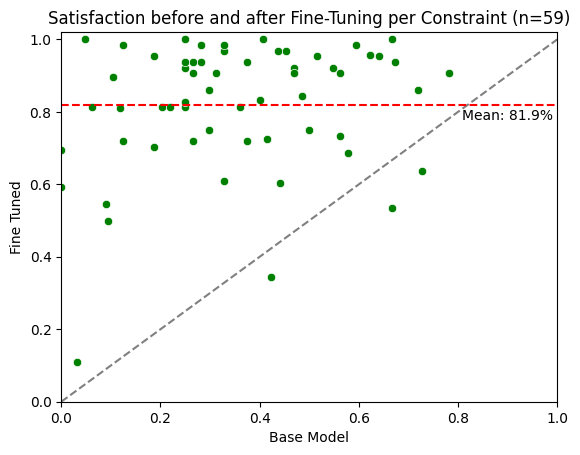

In [15]:
plot_metrics('base_constraint', "Base Model",
             'test_no_sampling_constraint', "Fine Tuned",
             f"Satisfaction before and after Fine-Tuning per Constraint (n={len(metrics.keys())})",
            ylim=(0,1.02), xlim=(0,1), diagonal=True, annotate=False, mean='base_constraint')

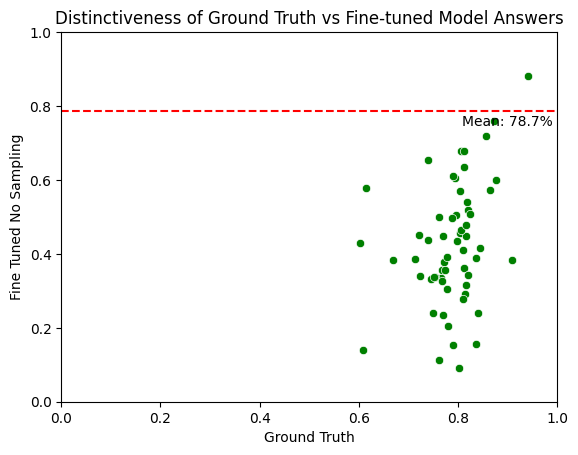

In [18]:
plot_metrics('truth_distinct', "Ground Truth",
             'test_no_sampling_distinct', "Fine Tuned No Sampling",
             "Distinctiveness of Ground Truth vs Fine-tuned Model Answers",
            ylim=(0,1), xlim=(0,1), mean='truth_distinct')

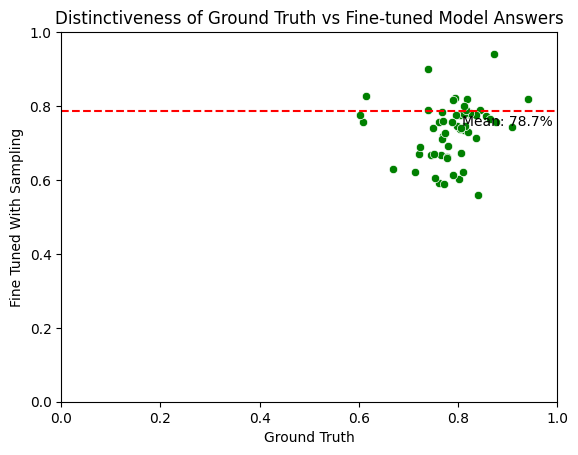

In [20]:
plot_metrics('truth_distinct', "Ground Truth",
             'test_distinct', "Fine Tuned With Sampling",
             "Distinctiveness of Ground Truth vs Fine-tuned Model Answers",
            ylim=(0,1), xlim=(0,1), mean='truth_distinct')

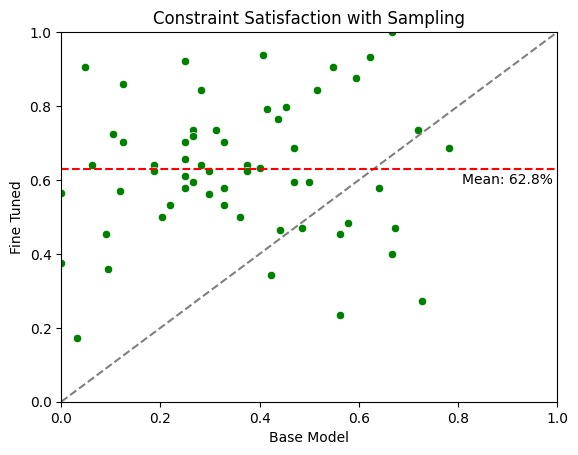

In [24]:
plot_metrics('base_constraint', "Base Model",
             'test_constraint', "Fine Tuned",
             "Constraint Satisfaction with Sampling",
            ylim=(0,1), xlim=(0,1), diagonal=True, annotate=False, mean='test_constraint')

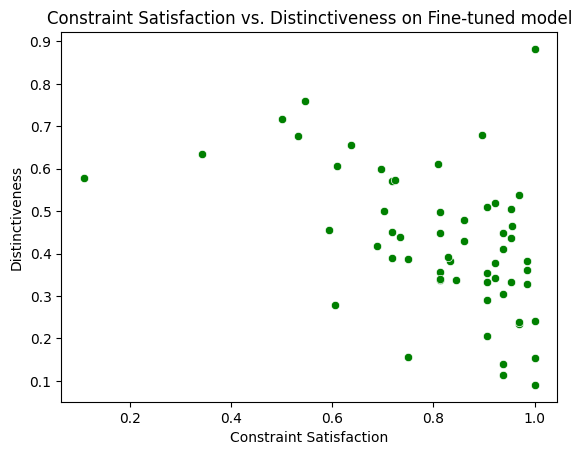

In [22]:
plot_metrics('test_no_sampling_constraint', "Constraint Satisfaction",
             'test_no_sampling_distinct', "Distinctiveness",
             "Constraint Satisfaction vs. Distinctiveness on Fine-tuned model",
             annotate=False)

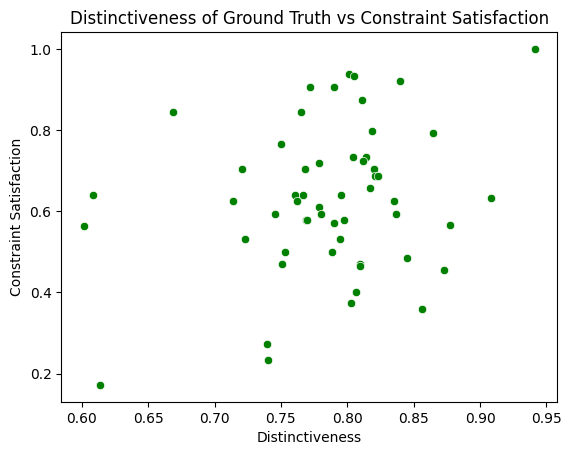

In [12]:
plot_metrics('truth_distinct', "Distinctiveness",
             'test_constraint', "Constraint Satisfaction",
             "Distinctiveness of Ground Truth vs Constraint Satisfaction",
             annotate=False)

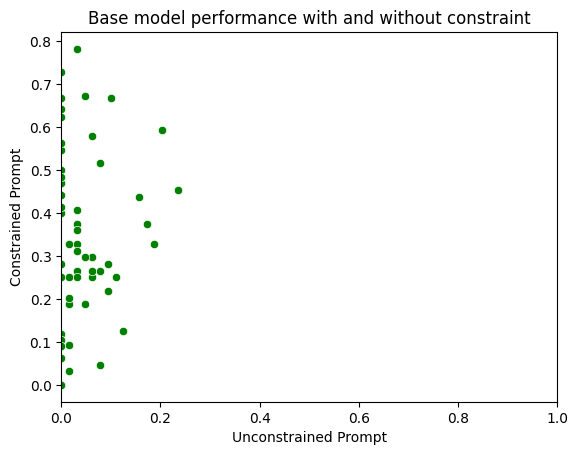

In [13]:
plot_metrics('unconstrained_constraint', "Unconstrained Prompt",
             'base_constraint', "Constrained Prompt",
             "Base model performance with and without constraint",
             annotate=False, xlim=(0,1))